### Libras Detection with Mediapipe and NN Classifier Tensorflow

# Libras (PTBR Hand Signal Language) Recognition 

* Proposed Solution: Use Google's Mediapipe Hands Detection to detect hands position and apply it to a image dataset for
Libras hand signals. This will generate a class - fingers coordinates dataset that can be used to train a simple NN Classifier
to recognize those signals. This is useful in order to avoid the computation of a image CNN, by only using a simple vector of coordinates
numbers, this method would be faster and requires much less processing, considering how fast Mediapipe hands detection already is.

* Advance: It's needed to make a better image dataset for the signals, with high quality and variety and also the addition of more signals.

* Advance: Use a set of frames instead a static image for hand signal classification, so it can be applied to signals that involve movement.

##### Refs:

* https://github.com/google/mediapipe

* I. L. O. Bastos, M. F. Angelo and A. C. Loula, "Recognition of Static Gestures Applied to Brazilian Sign Language (Libras)," 2015 28th SIBGRAPI Conference on Graphics, Patterns and Images, Salvador, 2015, pp. 305-312.


In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
from IPython.display import clear_output
import pandas as pd
import seaborn as sns

In [2]:
import sys
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV')
import OpCV_Utils

In [3]:
hands_df = pd.read_csv('hands_dataframe')
hands_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.530610,0.734979,0.687852,0.695875,0.772122,0.560489,0.777391,0.444213,0.785670,...,0.529562,0.619644,0.391117,0.545876,0.403106,0.496368,0.445098,0.573567,0.467922,0.626696
1,0.0,0.648609,0.859351,0.778897,0.797901,0.832064,0.652105,0.818550,0.546344,0.850461,...,0.638657,0.776330,0.464930,0.663796,0.510593,0.622864,0.560984,0.693026,0.587580,0.746618
2,0.0,0.361423,0.859630,0.224011,0.804758,0.173517,0.667868,0.179654,0.562697,0.152707,...,0.365145,0.773470,0.538554,0.669886,0.507316,0.643539,0.459220,0.710207,0.440000,0.761474
3,0.0,0.767182,0.829417,0.873378,0.738796,0.873948,0.582669,0.823329,0.485701,0.829521,...,0.724968,0.739878,0.517911,0.667061,0.545780,0.612058,0.618518,0.671339,0.660227,0.716618
4,0.0,0.483996,0.738014,0.326520,0.687574,0.235558,0.559320,0.221129,0.456594,0.203319,...,0.467640,0.639272,0.597188,0.538383,0.606877,0.498030,0.572900,0.572647,0.546903,0.626232


In [4]:
hands_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
5217,21.0,0.554259,0.625441,0.464854,0.553347,0.433579,0.437875,0.420882,0.355958,0.388358,...,0.619229,0.483154,0.779483,0.457556,0.862940,0.387345,0.911639,0.341631,0.955237,0.295481
5218,21.0,0.448022,0.621944,0.541257,0.553962,0.559150,0.434892,0.563110,0.343262,0.591839,...,0.388379,0.480652,0.216528,0.477261,0.125023,0.403096,0.080850,0.359216,0.043015,0.313312
5219,21.0,0.483697,0.557480,0.586212,0.504271,0.663735,0.398531,0.707334,0.314225,0.746055,...,0.442312,0.398659,0.338834,0.346869,0.288285,0.262188,0.260030,0.212683,0.240896,0.168712
5220,21.0,0.521369,0.562645,0.403477,0.501175,0.321168,0.385726,0.270212,0.293690,0.220791,...,0.560415,0.392422,0.663392,0.349528,0.709097,0.268464,0.740416,0.219352,0.763030,0.174171
5221,21.0,0.491919,0.547438,0.595190,0.489435,0.656917,0.379424,0.684472,0.287305,0.696737,...,0.422534,0.404935,0.315240,0.361236,0.252691,0.277596,0.214987,0.232511,0.188037,0.191336


In [5]:
hands_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
count,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,...,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000,5222.000000
mean,10.708541,0.507284,0.646971,0.540783,0.616234,0.553750,0.552719,0.545099,0.511875,0.530560,...,0.496860,0.504187,0.463593,0.517047,0.464097,0.487053,0.473765,0.495068,0.479545,0.498588
std,6.384422,0.119601,0.165066,0.152756,0.136494,0.191437,0.089258,0.184336,0.080797,0.180195,...,0.118186,0.150891,0.144733,0.082312,0.148349,0.097462,0.138962,0.119758,0.140828,0.144723
min,0.000000,0.126202,0.136481,0.099217,0.168632,0.045703,0.214025,0.072024,0.194368,0.024200,...,0.081010,0.067712,0.024138,0.214400,-0.016084,0.187152,0.005983,0.166142,-0.033901,0.078244
25%,5.000000,0.437048,0.597505,0.421159,0.548152,0.397500,0.495196,0.395415,0.460264,0.396481,...,0.419374,0.411853,0.353668,0.463703,0.354261,0.421268,0.383172,0.406999,0.393395,0.397675
50%,11.000000,0.510042,0.690916,0.554868,0.652099,0.584922,0.558393,0.574122,0.510366,0.544052,...,0.500942,0.526215,0.455019,0.519704,0.455563,0.487382,0.475889,0.509333,0.483808,0.525965
75%,16.000000,0.583472,0.757007,0.662308,0.712233,0.708498,0.611620,0.693893,0.562747,0.667533,...,0.576266,0.609348,0.565276,0.569554,0.563674,0.555070,0.560970,0.585250,0.568739,0.610162
max,21.000000,0.900615,0.947711,0.924613,0.887620,0.956116,0.799820,0.908184,0.793944,0.962808,...,0.916708,0.879123,0.973941,0.835755,1.010086,0.835654,0.982577,0.828938,1.023257,0.820010


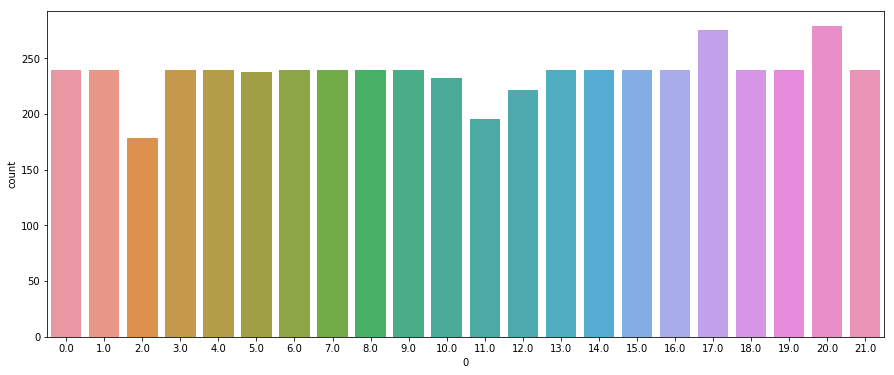

In [6]:
plt.figure(figsize=(15,6))
sns.countplot(hands_df['0'], label = 'Count');

In [ ]:
########### Tensorflow Import ###########

# ON CONDA: pip install tensorflow==2.0.0-alpha0 # If any problem -> pip uninstall numpy -> pip install numpy
import tensorflow as tf
from tensorflow.keras import layers, models

In [8]:
# NN Training Stopper Callback (after meeting desired condition)

class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.999):
            print('\n\n\nReached desired accuracy. Training canceled! \n\n\n')
            self.model.stop_training = True
            
trainingStopCallback = haltCallback()

In [9]:
data_input = hands_df.drop(['0'], axis = 1)
data_output = hands_df['0']

X = np.array(data_input, dtype = 'float32')
Y = np.array(data_output, dtype = 'float32')

# Let's split data in train and test:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 5) # 80% train, 20% test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3916, 42)
(1306, 42)
(3916,)
(1306,)


In [19]:
# Network Setup
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Dense(units = 500, activation = 'relu', input_shape = [42,]))
net.add(tf.keras.layers.Dense(units = 500, activation = 'relu'))
net.add(layers.Dense(64, activation = 'relu'))
# With 22 output classes:
net.add(layers.Dense(22, activation = 'softmax'))

net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               21500     
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_7 (Dense)              (None, 22)                1430      
Total params: 305,494
Trainable params: 305,494
Non-trainable params: 0
_________________________________________________________________


In [20]:
epochs = 500
batch_size = 32

# Using Sparse, no need to encode output classes:
net.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics = ['accuracy'])
history = net.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, callbacks = [trainingStopCallback])

Epoch 1/500
3916/3916 [==============================] - 1s 307us/sample - loss: 2.5788 - accuracy: 0.2140
Epoch 2/500
3916/3916 [==============================] - 1s 192us/sample - loss: 1.3730 - accuracy: 0.5360
Epoch 3/500
3916/3916 [==============================] - 1s 188us/sample - loss: 0.8551 - accuracy: 0.6872
Epoch 4/500
3916/3916 [==============================] - 1s 183us/sample - loss: 0.7008 - accuracy: 0.7303
Epoch 5/500
3916/3916 [==============================] - 1s 186us/sample - loss: 0.5843 - accuracy: 0.7827
Epoch 6/500
3916/3916 [==============================] - 1s 183us/sample - loss: 0.5267 - accuracy: 0.8001
Epoch 7/500
3916/3916 [==============================] - 1s 187us/sample - loss: 0.4646 - accuracy: 0.8345
Epoch 8/500
3916/3916 [==============================] - 1s 206us/sample - loss: 0.4391 - accuracy: 0.8353
Epoch 9/500
3916/3916 [==============================] - 1s 187us/sample - loss: 0.3965 - accuracy: 0.8570
Epoch 10/500
3916/3916 [=============

Epoch 77/500
3916/3916 [==============================] - 1s 180us/sample - loss: 0.0306 - accuracy: 0.9898
Epoch 78/500
3916/3916 [==============================] - 1s 180us/sample - loss: 0.0392 - accuracy: 0.9854
Epoch 79/500
3916/3916 [==============================] - 1s 184us/sample - loss: 0.0575 - accuracy: 0.9808
Epoch 80/500
3916/3916 [==============================] - 1s 179us/sample - loss: 0.0235 - accuracy: 0.9944
Epoch 81/500
3916/3916 [==============================] - 1s 178us/sample - loss: 0.0292 - accuracy: 0.9908
Epoch 82/500
3916/3916 [==============================] - 1s 184us/sample - loss: 0.0246 - accuracy: 0.9906
Epoch 83/500
3916/3916 [==============================] - 1s 181us/sample - loss: 0.0661 - accuracy: 0.9752
Epoch 84/500
3916/3916 [==============================] - 1s 178us/sample - loss: 0.0841 - accuracy: 0.9714
Epoch 85/500
3916/3916 [==============================] - 1s 182us/sample - loss: 0.0483 - accuracy: 0.9811
Epoch 86/500
3916/3916 [====

In [21]:
# Testing model with the test data using evaluate:
evaluation = net.evaluate(X_test, y_test)
evaluation

1306/1306 [==============================] - 0s 159us/sample - loss: 0.0340 - accuracy: 0.9916


[0.03398510513921335, 0.9915773]

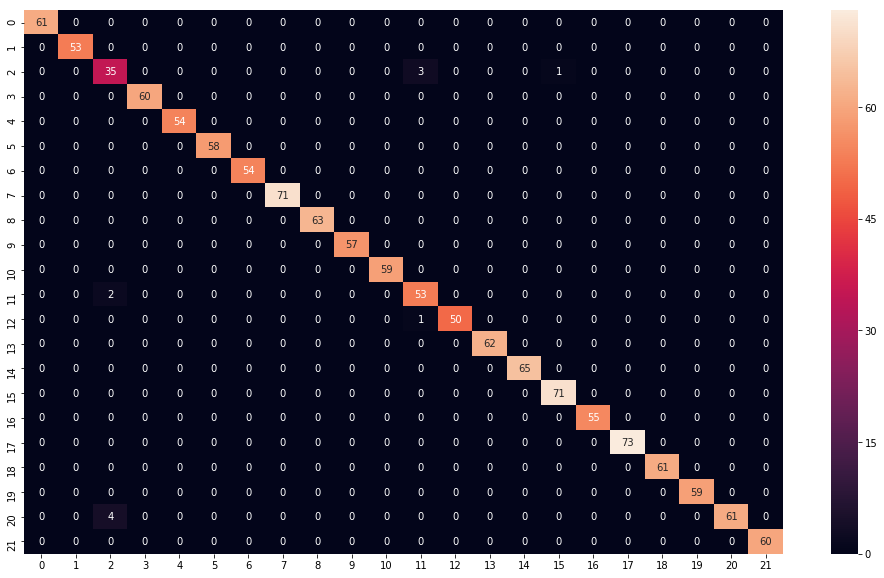

In [22]:
predicted_classes = net.predict_classes(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (17,10))
sns.heatmap(cm, annot=True)

In [23]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

from sklearn.metrics import classification_report
num_classes = 22
target_names = ["Letter {}".format(letters[i]) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Letter A       1.00      1.00      1.00        61
    Letter B       1.00      1.00      1.00        53
    Letter C       0.85      0.90      0.88        39
    Letter D       1.00      1.00      1.00        60
    Letter E       1.00      1.00      1.00        54
    Letter F       1.00      1.00      1.00        58
    Letter G       1.00      1.00      1.00        54
    Letter I       1.00      1.00      1.00        71
    Letter L       1.00      1.00      1.00        63
    Letter M       1.00      1.00      1.00        57
    Letter N       1.00      1.00      1.00        59
    Letter O       0.93      0.96      0.95        55
    Letter P       1.00      0.98      0.99        51
    Letter Q       1.00      1.00      1.00        62
    Letter R       1.00      1.00      1.00        65
    Letter S       0.99      1.00      0.99        71
    Letter T       1.00      1.00      1.00        55
    Letter U       1.00    

In [24]:
net.save('Libras_Classifier_net')
loaded_net = tf.keras.models.load_model('Libras_Classifier_net')
loaded_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               21500     
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32064     
_________________________________________________________________
dense_7 (Dense)              (None, 22)                1430      
Total params: 305,494
Trainable params: 305,494
Non-trainable params: 0
_________________________________________________________________


In [25]:
def hand_detection(frame, bboard, results, mpDraw, mpHands):
    
    for handLandmarks in results.multi_hand_landmarks:
            
        landmarks_list = []
        lm_list_not_scaled = []
            
        for id, lm in enumerate(handLandmarks.landmark):
            h, w, c = frame.shape
            cX, cY  = int(lm.x*w), int(lm.y*h)
                
            cv2.circle(frame, (cX, cY), 6, (205, 0, 0), cv2.FILLED)
            cv2.putText(frame, '{}'.format(id), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150, 0, 0), 1)
                
            cv2.circle(bboard, (cX, cY), 6, (205, 0, 0), cv2.FILLED)
            cv2.putText(bboard, '{}'.format(id), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1)
                
            landmarks_list.append([id, cX, cY])
            lm_list_not_scaled.append([id, lm.x, lm.y])
            
        mpDraw.draw_landmarks(frame, handLandmarks, mpHands.HAND_CONNECTIONS)
        mpDraw.draw_landmarks(bboard, handLandmarks, mpHands.HAND_CONNECTIONS)
                
        return landmarks_list, lm_list_not_scaled

In [27]:
# Testing with Video:

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

# Object Instances:
mpDraw = mp.solutions.drawing_utils
mpHands = mp.solutions.hands

hands = mpHands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.4, min_tracking_confidence=0.4)

# Load Video:
cap = cv2.VideoCapture('libras_2.mp4')
video_fps = cap.get(cv2.CAP_PROP_FPS)

while True:
        
    start = time.time()
    
    success, frame = cap.read()
            
    if not success:
        print('Server OFF')
        break
        
    #####################################################################################################################
    
    results = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    bboard = np.zeros_like(frame)    
                                
    try:
        _, lm = hand_detection(frame, bboard, results, mpDraw, mpHands)

        input_array = np.array([lm[0][1], lm[0][2], lm[1][1], lm[1][2], lm[2][1], lm[2][2],
                               lm[3][1], lm[3][2], lm[4][1], lm[4][2], lm[5][1], lm[5][2],
                               lm[6][1], lm[6][2], lm[7][1], lm[7][2], lm[8][1], lm[8][2],
                               lm[9][1], lm[9][2], lm[10][1], lm[10][2], lm[11][1], lm[11][2],
                               lm[12][1], lm[12][2], lm[13][1], lm[13][2], lm[14][1], lm[14][2],
                               lm[15][1], lm[15][2], lm[16][1], lm[16][2], lm[17][1], lm[17][2],
                               lm[18][1], lm[18][2], lm[19][1], lm[19][2], lm[20][1], lm[20][2],], dtype=np.float32)

        input_array = input_array.reshape((1,42))

        output = loaded_net.predict(input_array)
                
        clear_output(wait=True)
        
        if (np.max(output) < 0.2):
            
            cv2.putText(bboard, 'Could Not Detect any Letter', (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (255, 255, 255), 2)

        else:
            
            letter_result = letters[int(np.argmax(output))]

            cv2.putText(bboard, 'Detected Letter: ' + letter_result + ' {}%'.format(int(100*np.max(output))), (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (255, 255, 255), 2)
        
    except:
        
        cv2.putText(bboard, 'Could Not Detect any Letter', (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (255, 255, 255), 2)
        
    frame_stack = OpCV_Utils.stackImgs([[frame, bboard]], scale = 0.5, sep_lines=True)
                
    #####################################################################################################################
    
    # Keyboard Controls:
    
    key = cv2.waitKey(1) or 0xff   
        
    if key == ord('k'):
        break
        
    if key == ord('p'):       
        cv2.waitKey(0)
        
    end = time.time()

    frame_time = (end - start) + 0.0001
    fps = np.floor(1/frame_time)
            
    cv2.putText(frame_stack, "FPS: {}".format(fps), (9,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    cv2.imshow("Output", frame_stack)
    
cv2.destroyAllWindows()
cap.release()

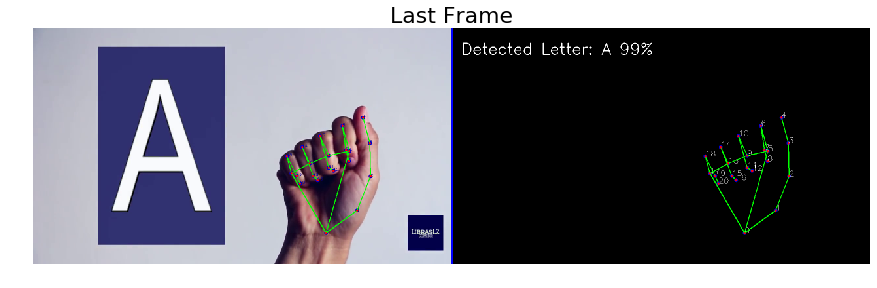

In [96]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))

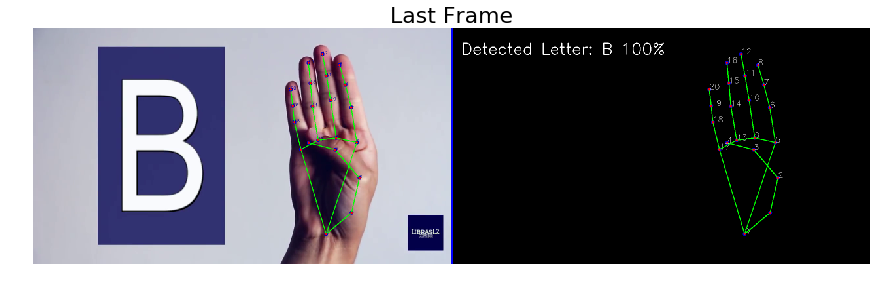

In [99]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))

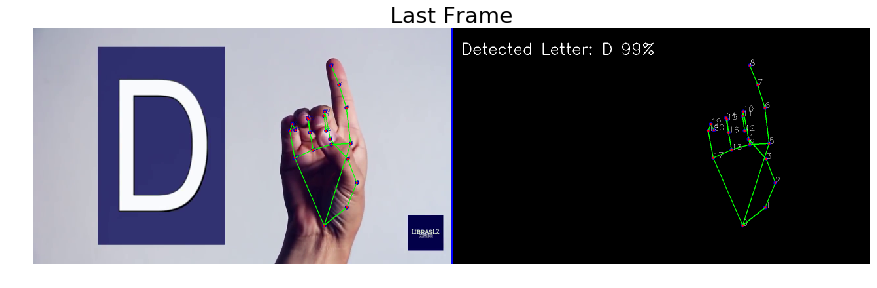

In [101]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))

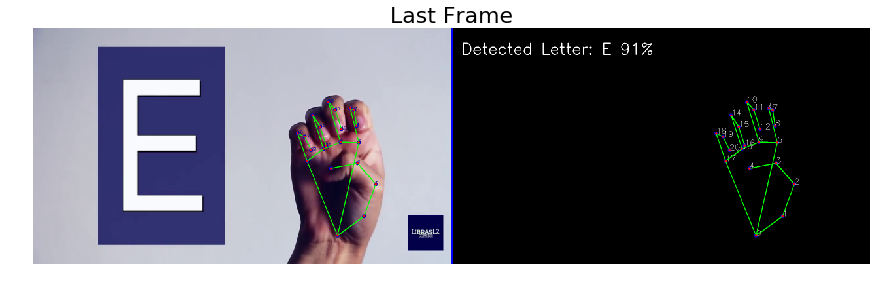

In [103]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))

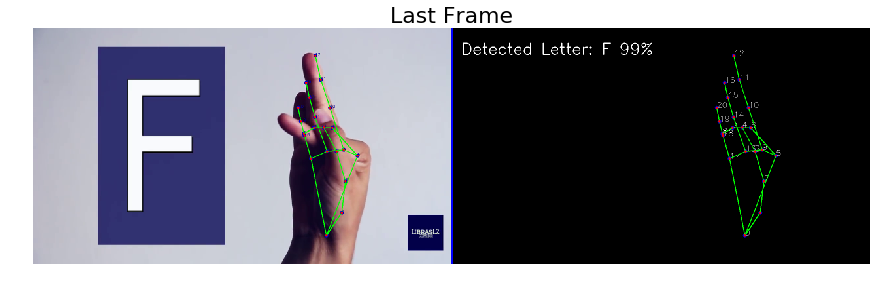

In [105]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))

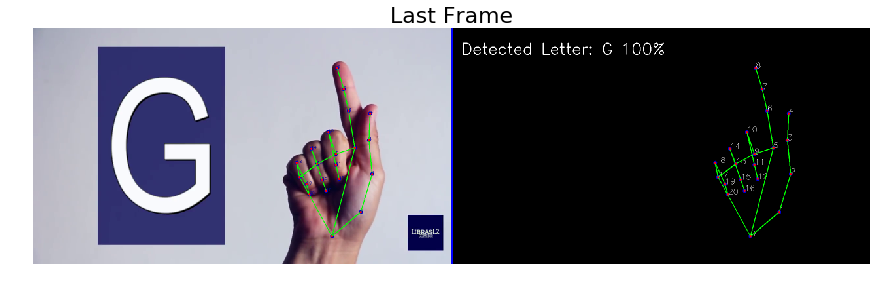

In [107]:
OpCV_Utils.show_single_img_plt(cv2.cvtColor(frame_stack, cv2.COLOR_BGR2RGB), 'Last Frame', fig_size=(15,15))